In [11]:
using Plots
#using Pkg; Pkg.add("DistributedArrays")
#using Transducers
using FileIO
using Distributed
using DistributedArrays
using DistributedArrays.SPMD
#@everywhere using SharedArrays
@everywhere using Distributed
@everywhere using DistributedArrays
@everywhere using DistributedArrays.SPMD
using BenchmarkTools

In [2]:
const N_workers = 4
addprocs(N_workers)

4-element Vector{Int64}:
 2
 3
 4
 5

In [3]:
nprocs()
procs()

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [5]:
#rmprocs(6,7,8,9)
workers()
#nworkers()

4-element Vector{Int64}:
 2
 3
 4
 5

In [7]:
@everywhere include_string(Main, $(read("aux_functions.jl", String)), "aux_functions.jl")

In [6]:
order = 1
const L = 5
const N = 80000
#const N = 20000
const J = 50
const κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
p = (L, N, J, κ, dx, order)

(5, 80000, 50, 1.2566370614359172, 0.1, 1)

In [22]:
d_closeall()


In [23]:
#DS = dzeros((J,4), workers(), [1,4])
DS = dzeros((J,nworkers()), workers(), [1,nworkers()]);
#pars = dzeros((N), workers(), [nworkers()] )

50×4 DArray{Float64, 2, Matrix{Float64}}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 ⋮              
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [24]:
#pars = dzeros((20), workers()[1:nprocs()-1], [nprocs()-1])
pars = zeros(2N)
#pars = dones((N,), workers(), [nworkers()] );
par_dis = load("Initial_Distributions/par_dis_L5_N8_5_theta001.jld2", "par_dis");
reorder_particles!(par_dis,pars)

In [25]:
Dpars = distribute(pars);

In [32]:


Sf = zeros(J)
spmd(get_current_ro_par, Dpars, DS, p)
for j in 1:J
    for i in 1:nworkers()
        Sf[j] += DS[j,i]
    end
end


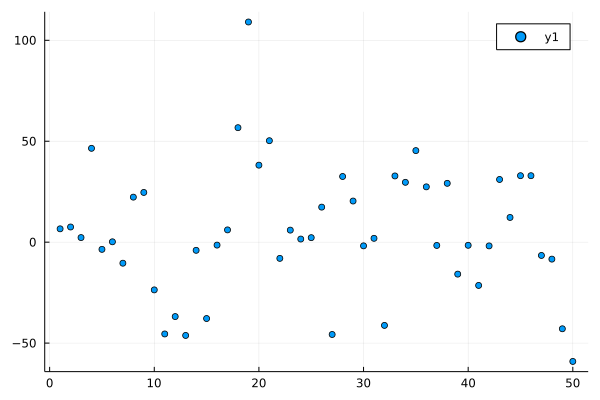

In [33]:
Plots.scatter(Sf)

In [36]:
S = zeros(J)
get_current_ro!(pars, S, p)


In [37]:
(S - Sf)'*(S-Sf)

2.3478587322990654e-25

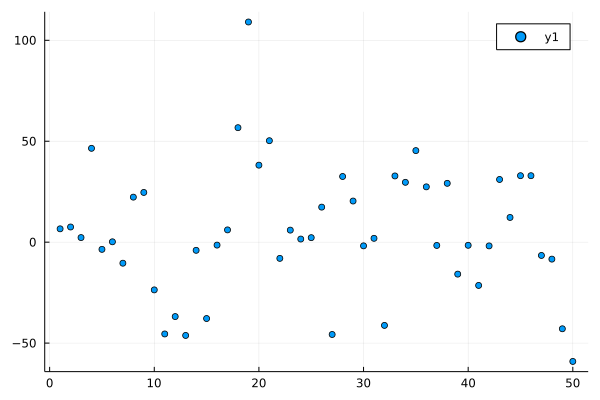

In [38]:
Plots.scatter(S)

In [3]:
cores = [1 2 4 8 16 32]
times = [27. 19.3 37.1 51.9 52.1 185 371.8]
Plots.scatter(cores,times)


UndefVarError: UndefVarError: Plots not defined

In [ ]:
threads [2 4 8 16 32 42]
time_t_2[3034 1700 868.586 495.360 325.903 309.803]
time_t_1[ 2_935 1_655 856.016 487.830 328.558 300.762]